# Introduction

This strategy is a moving average crossover system. It buys (goes long) when a faster-period Simple Moving Average (SMA) crosses above a slower-period SMA, signaling an uptrend. Conversely, it sells (goes short) when the faster SMA crosses below the slower SMA, indicating a downtrend. If an opposing signal occurs while a position is open, the strategy reverses its position to align with the new trend direction.

# Step 1) Data Preparation

To prepare the data we read using Athena (and SQL, rather than reading from a bucket as an object), deploy dependencies locally on the Notebook instance, indexes by date and splits the data into a training and validation datasets.

In [1]:
%run init_model.py 'algo_simple_sma'

algo_simple_sma


In [2]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-616431823260'

In [3]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

In [4]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
import pandas as pd
from sqlalchemy import create_engine
from pyathena import connect
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df_ohlcv_INTC = pd.read_sql("SELECT dt,open,high,low,close,volume FROM algo_data.hist_ohlcv_daily_alphavantage \
                WHERE dt >= DATE '2021-01-01' AND dt < DATE '2025-01-01' ORDER BY dt;", engine)
df_ohlcv_INTC.set_index(pd.DatetimeIndex(df_ohlcv_INTC['dt']),inplace=True)
del df_ohlcv_INTC['dt']
df_ohlcv_INTC.to_csv('local/'+algo_name+'/input/data/training/data.csv')
df_ohlcv_INTC.head()

,open,high,low,close,volume
dt,,,,,
2021-01-04,49.890,51.39,49.4016,49.67,46102459.0
2021-01-05,49.445,50.83,49.3300,50.61,24866563.0
2021-01-06,50.435,52.15,50.2000,51.10,36809644.0
2021-01-07,51.490,52.69,51.3000,52.19,32092336.0
2021-01-08,52.450,52.53,51.2700,51.65,34625379.0


<Axes: xlabel='dt'>

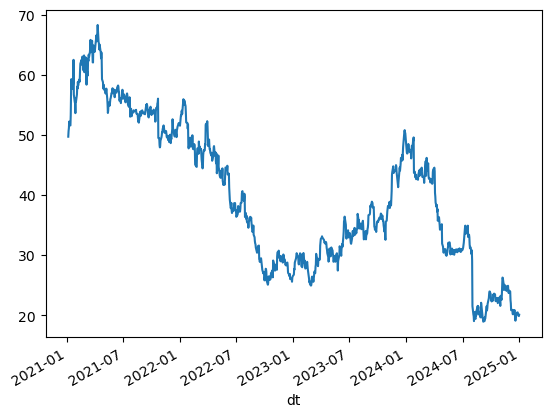

In [6]:
%matplotlib inline
df_ohlcv_INTC["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `fast_period` = Fast Period for Moving Average Indicator in min (e.g. 50)
* `slow_period` = Slow Period for Moving Average Indicator in min (e.g. 200)
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is to reduce the number of trades that get triggered by increasing the slow and fast period. Longer periods tend to perform better. 

In [7]:
%%writefile local/{algo_name}/input/config/hyperparameters.json
{ "fast_period" : "5",
  "slow_period" : "50",
  "size" : "100"
}

Overwriting local/algo_simple_sma/input/config/hyperparameters.json


In [8]:
%run update_config.py $algo_name

config={"fast_period": "5", "slow_period": "50", "size": "100", "algo_name": "algo_simple_sma", "user": "user", "account": "616431823260", "region": "us-east-1"}


<Figure size 640x480 with 0 Axes>

# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to try different indicators like ExponentialMovingAverage or delay when trades are triggered and check crossover again before placing a trade.

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [9]:
%%writefile model/{algo_name}.py
import backtrader as bt
from algo_base import *

class MyStrategy(StrategyTemplate):

    def __init__(self):  # Initiation
        super(MyStrategy, self).__init__()
        self.config["fast_period"]=int(self.config["fast_period"])
        self.config["slow_period"]=int(self.config["slow_period"])
        self.config["size"]=int(self.config["size"])

        # Calculate indicators using Backtrader
        self.smaFast = bt.ind.SimpleMovingAverage(period=self.config["fast_period"])
        self.smaSlow = bt.ind.SimpleMovingAverage(period=self.config["slow_period"])
        self.size = self.config["size"]

    # Set cash and commissions
    def init_broker(broker):
        broker.setcash(100000.0)
        broker.setcommission(commission=0.0) 
        
    # Cerebro is an algo engine
    def add_data(cerebro):
        data = btfeeds.GenericCSVData(
            dataname=MyStrategy.TRAIN_FILE,
            dtformat=('%Y-%m-%d'),
            timeframe=bt.TimeFrame.Days,
            # These are just indicies of columns in the file
            datetime=0,
            time=-1,
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=-1
        )
        cerebro.adddata(data)

    # Processnext data point (in our case a daily bar
    def next(self):  # Processing
        super(MyStrategy, self).next()
        dt=self.datas[0].datetime.datetime(0)
        if not self.position:
            if self.smaFast[0] > self.smaSlow[0]:
                self.buy(size=self.size) # Go long
            else:
                self.sell(size=self.size) # Go short
        elif self.position.size>0 and self.smaFast[0] < self.smaSlow[0]:
            self.sell(size=2*self.size) # Go short
        elif self.position.size<0 and self.smaFast[0] > self.smaSlow[0]:          
            self.buy(size=2*self.size) # Go long

Overwriting model/algo_simple_sma.py


# Step 4) Backtest Locally

In this phase we create a container, which consists of the execution environment (defined in the Dockerfile), maps the local storage which contains data and hyperparameters, and uses functionality from the backtesting library to calculate the performance of the strategy - win/loss streak. drawdown, PnL, etc.
Please note that the initial docker build may take a few minutes. Subsequent runs are fast

In [10]:
# Build Local Algo Image
!docker build -t $algo_name .
!docker run -v $(pwd)/local/$algo_name:/opt/ml --rm $algo_name train

[+] Building 0.0s (0/0)  docker:default
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.36kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
[+] Building 0.2s (11/11) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.36kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 93B                                           0.0s
 => [1/6] FROM docker.io/tensorflow/tensorflow:nightly-jupyter@sha256:4cc  0.0s


[2016-09-08 23:59:59.999989] SOD:cash=99239.00
[2016-09-09 23:59:59.999989] SOD:cash=99139.00
[2016-09-10 23:59:59.999989] SOD:cash=99139.00
[2016-09-11 23:59:59.999989] SOD:cash=99139.00
[2016-09-12 23:59:59.999989] SOD:cash=99203.00
[2016-09-13 23:59:59.999989] SOD:cash=99156.00
[2016-09-14 23:59:59.999989] SOD:cash=99157.00
[2016-09-15 23:59:59.999989] SOD:cash=99251.00
[2016-09-16 23:59:59.999989] SOD:cash=99362.00
[2016-09-17 23:59:59.999989] SOD:cash=99362.00
[2016-09-18 23:59:59.999989] SOD:cash=99362.00
[2016-09-19 23:59:59.999989] SOD:cash=99311.00
[2016-09-20 23:59:59.999989] SOD:cash=99309.00
[2016-09-21 23:59:59.999989] SOD:cash=99340.00
[2016-09-22 23:59:59.999989] SOD:cash=99350.00
[2016-09-23 23:59:59.999989] SOD:cash=99314.00
[2016-09-24 23:59:59.999989] SOD:cash=99314.00
[2016-09-25 23:59:59.999989] SOD:cash=99314.00
[2016-09-26 23:59:59.999989] SOD:cash=99260.00
[2016-09-27 23:59:59.999989] SOD:cash=99313.00
[2016-09-28 23:59:59.999989] SOD:cash=99339.00
[2016-09-29 2

[2017-05-12 23:59:59.999989] SOD:cash=98838.00
[2017-05-13 23:59:59.999989] SOD:cash=98838.00
[2017-05-14 23:59:59.999989] SOD:cash=98838.00
[2017-05-15 23:59:59.999989] SOD:cash=98848.00
[2017-05-16 23:59:59.999989] SOD:cash=98867.00
[2017-05-17 23:59:59.999989] SOD:cash=98789.00
[2017-05-18 23:59:59.999989] SOD:cash=98807.00
[2017-05-19 23:59:59.999989] SOD:cash=98825.00
[2017-05-20 23:59:59.999989] SOD:cash=98825.00
[2017-05-21 23:59:59.999989] SOD:cash=98825.00
[2017-05-22 23:59:59.999989] SOD:cash=98862.00
[2017-05-23 23:59:59.999989] SOD:cash=98871.00
[2017-05-24 23:59:59.999989] SOD:cash=98897.00
[2017-05-25 23:59:59.999989] SOD:cash=98911.00
[2017-05-26 23:59:59.999989] SOD:cash=98911.00
[2017-05-27 23:59:59.999989] SOD:cash=98911.00
[2017-05-28 23:59:59.999989] SOD:cash=98911.00
[2017-05-29 23:59:59.999989] SOD:cash=98911.00
[2017-05-30 23:59:59.999989] SOD:cash=98903.00
[2017-05-31 23:59:59.999989] SOD:cash=98896.00
[2017-06-01 23:59:59.999989] SOM:chg=-129.00,cash=98897.00
[

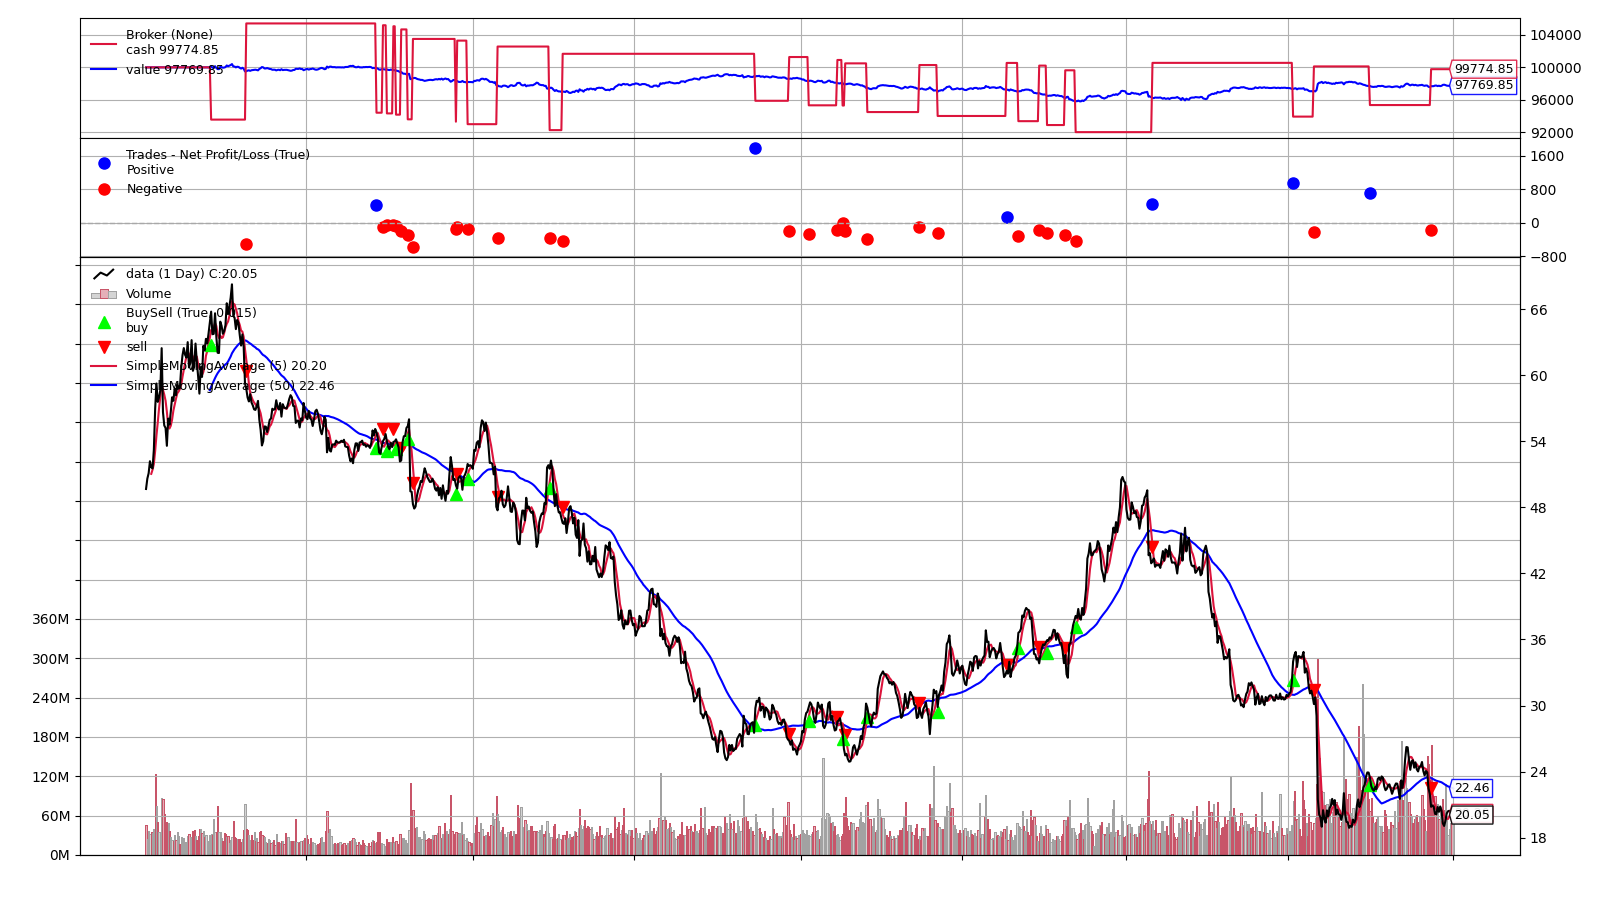

In [11]:
from IPython.display import Image
Image(filename='local/'+algo_name+'/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready, move on to the next step.

# Step 5) Backtest on SageMaker and submit performance
Here we do the same backtesting, which was done localy in the previous step, just on the cluster. We push the local image to the container registry, then spin a Sagemaker cluster (you can define the number of instances in its config). This is serverless - i.e. AWS will take care of provisioning the compute resources

In [12]:
# Deploy Algo Image to ECS
!./build_and_push.sh $algo_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/0)  docker:default
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.36kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:nightly-  0.1s
[+] Building 0.3s (11/11) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.36kB                                     0.0s
 => [

In [13]:
#Run Remote test via SageMaker

import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+algo_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+algo_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
print(config)

prefix=algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

INFO:sagemaker:Creating training-job with name: algo-simple-sma-2025-07-10-17-46-11-725


s3://sagemaker-us-east-1-616431823260/data
{'fast_period': '5', 'slow_period': '50', 'size': '100', 'algo_name': 'algo_simple_sma', 'user': 'user', 'account': '616431823260', 'region': 'us-east-1'}
2025-07-10 17:46:13 Starting - Starting the training job...
2025-07-10 17:46:37 Starting - Preparing the instances for training...
2025-07-10 17:47:05 Downloading - Downloading input data...
2025-07-10 17:47:31 Downloading - Downloading the training image......
2025-07-10 17:48:42 Training - Training image download completed. Training in progress.
2025-07-10 17:48:42 Uploading - Uploading generated training modelimport:algo_simple_sma
<class 'algo_simple_sma.MyStrategy'>
[INIT]:config:/opt/ml/input/config/hyperparameters.json={'account': '616431823260', 'algo_name': 'algo_simple_sma', 'fast_period': '5', 'region': 'us-east-1', 'size': '100', 'slow_period': '50', 'user': 'user'}
[2021-03-16 23:59:59.999989] SOD:cash=100000.00
[2021-03-17 23:59:59.999989] BUY EXECUTED, Price: 64.22, PNL: 0.00,

In [14]:
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,-2230.15
1,0.0,algo:sharpe_ratio,-1.34


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


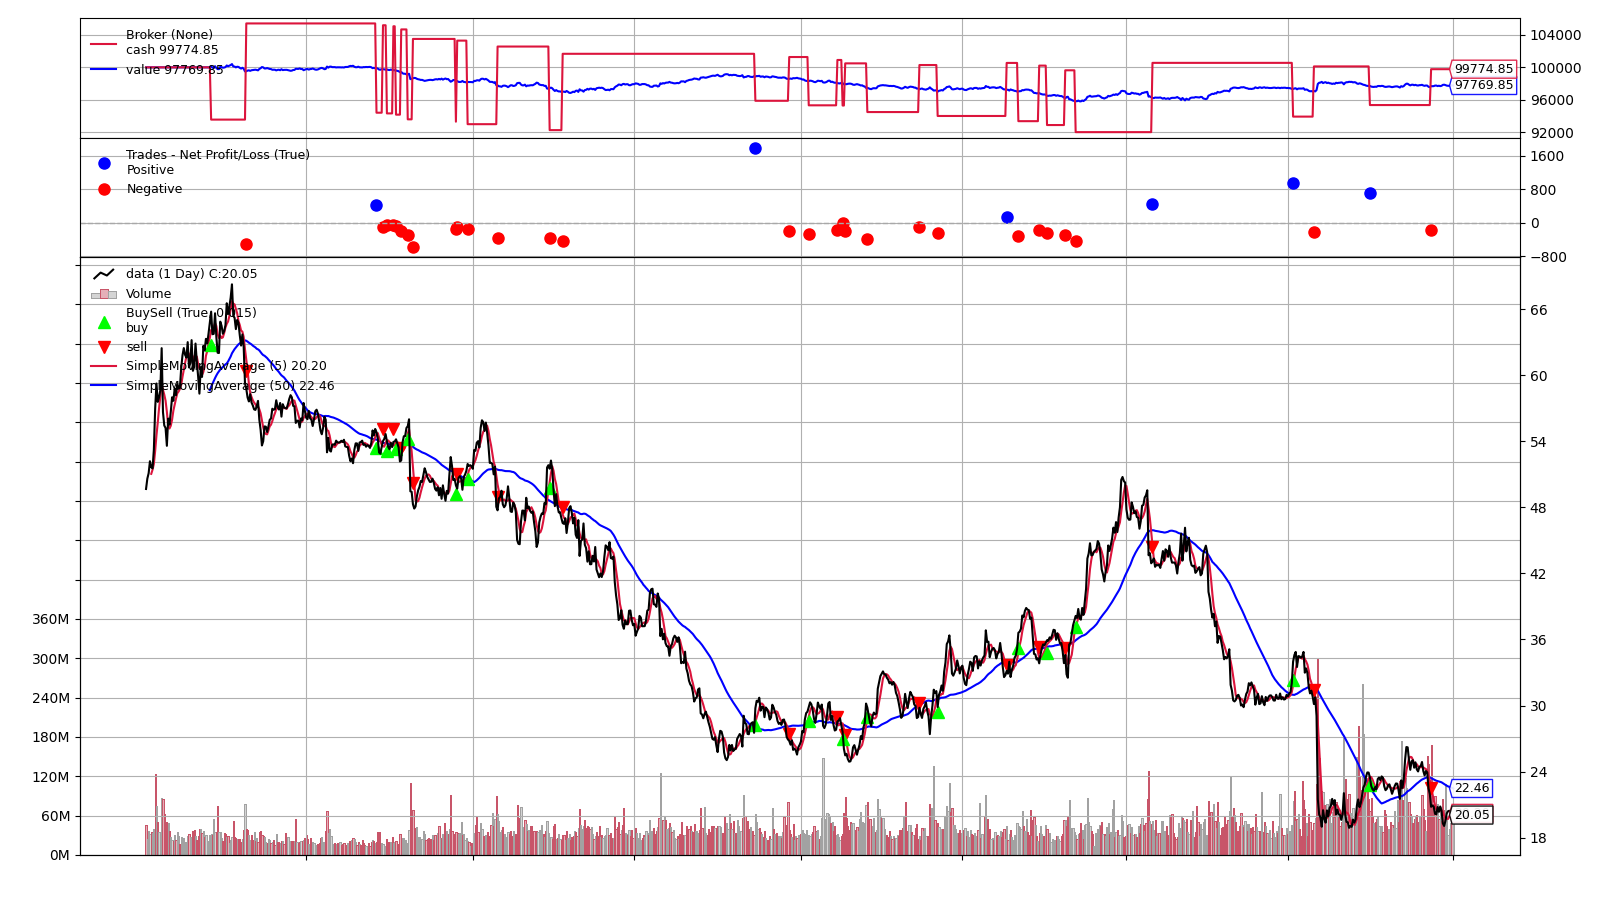

In [15]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 